In [1]:
import numpy as np
import stim

import tree_code_helper
from rgs_config import Node, Pauli, RgsConfig
from rgs_theoretical_model import prob_rgs_trial

### Checkpoints

- apply loss to every photons?
- track every side effects 
    - every time there's a measurement occurs
    - photons (excluding last level) from push-out of emitters
    - photons (first-level only) from the joining outer with inner qubits
    - anchor emitter from joining outer with inner qubits
    - recap
        - inner photons (non first/non last): from generations
        - inner photons first-level: from outer/inner join
        - inner photons first-level: from two halves joining
        - outer photons: from joining inner/outer (also track the H)
        - anchor: outer/inner join

In [2]:
def helper_apply_photon_loss(conf: RgsConfig, photon: int) -> bool:
    """returns a bool indicating whether the qubit is lost or not"""
    conf.total_photons += 1
    if conf.rng.random() >= conf.loss_probability:
        return False
    conf.lost_photons += 1
    conf.t.x_error(photon, p=0.5)
    conf.t.z_error(photon, p=0.5)
    return True


def helper_update_eigenvalue_with_side_effect(conf: RgsConfig):

    def __update_eigenvalue_with_side_effect_recurse(root: Node):
        if (not root.is_lost) and (root.measurement_basis == Pauli.X) and (root.has_z):
            root.eigenvalue = not root.eigenvalue
        for v in root.children:
            __update_eigenvalue_with_side_effect_recurse(v)

    for meas_tree in conf.measurement_trees:
        for root in meas_tree:
            __update_eigenvalue_with_side_effect_recurse(root)


def helper_decode_logical_result(conf: RgsConfig) -> bool:
    """decode logical qubit from all measurements (all info stored in config)
    and returns a boolean indicating whether all inner qubits can be decoded or not"""
    for i, meas_tree in enumerate(conf.measurement_trees):
        x_decode_count = 0
        z_decode_count = 0
        for arm, root in enumerate(meas_tree):
            if conf.succeeded_bsm_arm_indices[i // 2] == arm:
                x_decode_count += 1
                conf.logical_results[i][arm] = tree_code_helper.decode_tree_logical_x(root)
            else:
                z_decode_count += 1
                conf.logical_results[i][arm] = tree_code_helper.decode_tree_logical_z(root)
    return all([m is not None for arms in conf.logical_results for m in arms])

### General Idea of how to optimize the simulation

1. We keep the required qubits in the system at a time to the minimum, i.e., minimum emitters and photons.
    1. we simulate hop-by-hop fashion, creating two half-RGSs, and the action at the ABSA between them.
    2. Beyond the first hop, the Bell pairs created thus far are stored in two memories between two nodes (thus 2 memories here)
    3. The next hop, creating by another set of emitters and at most 2 photons at a time (2 anchors; 2 outer emitters; 2 photons; one set of inner qubit emitters |bv|)

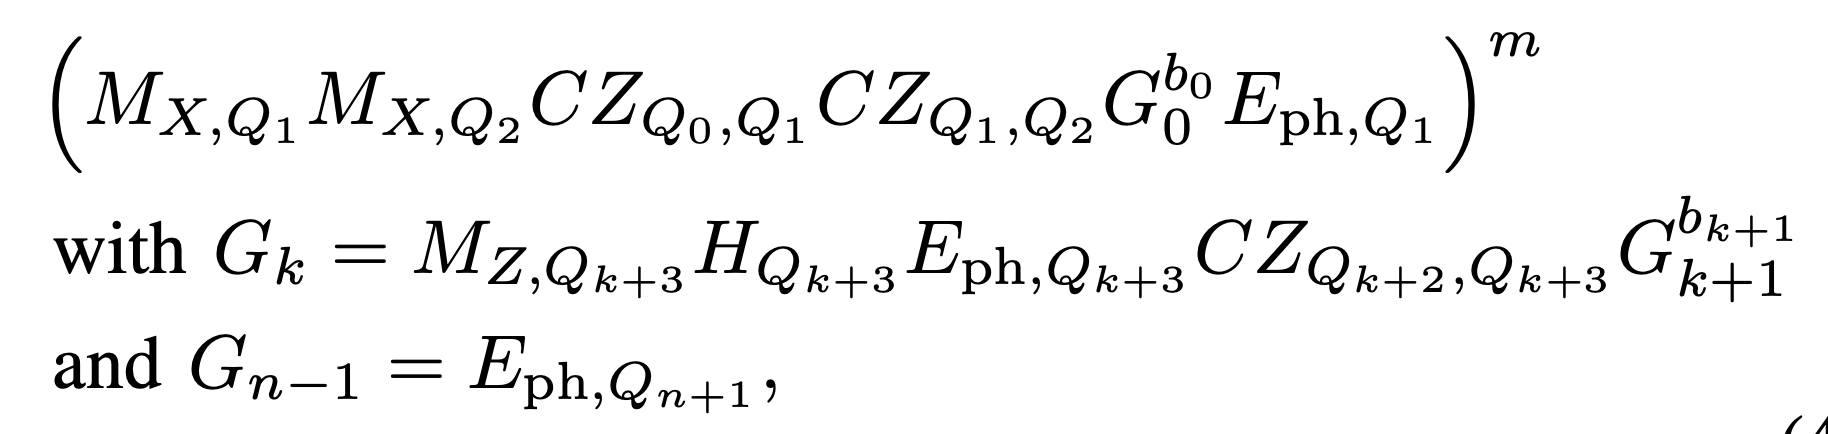

In [3]:
def generate_and_measure_inner_qubit(conf: RgsConfig, logical_basis: Pauli, root: Node):
    """Generate and measure an inner logical qubit, which comprises of lots of physical qubits."""

    # specifying the basis (i.e., X or Z) will be measured in the odd level while even will be the other basis (i.e., Z or X)
    # this is opposite of what we wrote in the paper since we count the level of the tree from 0 (in the paper we count from 1)
    even_basis = logical_basis
    if even_basis == Pauli.X:
        odd_basis = Pauli.Z
    else:
        odd_basis = Pauli.X
    n = len(conf.bv)

    # postorder lists
    postorder_measurement_bases: list[Pauli | None] = []
    postorder_measurement_results: list[bool | None] = []
    postorder_photon_lost: list[bool] = []
    postorder_side_effects: list[bool] = []

    # short hand
    t = conf.t
    photon = conf.photon
    emitters = conf.emitters

    def __recurse_generate_and_measure(i):
        # one call generates one child (subtree) of emitter i-th
        # from having (j, b_{i+1}, b{i+2}, ..., b_{n-1}) to (j + 1, b_{i+1}, b{i+2}, ..., b_{n-1})
        # initially, j is 0 for the first call
        # we assume that the emitters are always in the |+> state,
        # so we need to reinitialize it every time we perform measurements on an emitter.
        basis = odd_basis if i % 2 == 1 else even_basis
        if i == n - 1:
            # generation part: G_{n-1}
            t.reset(photon)
            t.cx(emitters[i], photon)
            t.h(photon)  # to fix up the H side effect

            # measurement part
            if helper_apply_photon_loss(conf, photon):
                postorder_photon_lost.append(True)
                postorder_measurement_bases.append(None)
                postorder_measurement_results.append(None)
                postorder_side_effects.append(False)
            else:
                if basis == Pauli.X:
                    t.h(photon)
                postorder_photon_lost.append(False)
                postorder_measurement_bases.append(basis)
                postorder_measurement_results.append(t.measure(photon))
                postorder_side_effects.append(False)
        else:
            # generation part: G_k
            for _ in range(conf.bv[i + 1]):
                # G_{i+1} ^ (b_{i+1}); this is anchored at emitter[i+1]
                __recurse_generate_and_measure(i + 1)
            t.cz(emitters[i], emitters[i + 1])
            t.reset(photon)
            t.cx(emitters[i + 1], photon)
            t.h(emitters[i + 1])
            postorder_side_effects.append(t.measure(emitters[i + 1]))
            t.reset_x(emitters[i + 1])  # reinitialize emitter q_{i+1}

            # measure the newly created photon at level k
            if helper_apply_photon_loss(conf, photon):
                postorder_photon_lost.append(True)
                postorder_measurement_bases.append(None)
                postorder_measurement_results.append(None)
            else:
                if basis == Pauli.X:
                    t.h(photon)
                postorder_photon_lost.append(False)
                postorder_measurement_bases.append(basis)
                postorder_measurement_results.append(t.measure(photon))

    for _ in range(conf.bv[0]):
        __recurse_generate_and_measure(0)

    postorder_nodes = root.get_postorder_traversal()

    # we don't need the last entry since it is the outer photon
    for i, u in enumerate(postorder_nodes[:-1]):
        u.has_z = postorder_side_effects[i]
        u.measurement_result = u.eigenvalue = postorder_measurement_results[i]
        u.measurement_basis = postorder_measurement_bases[i]
        u.is_lost = postorder_photon_lost[i]

In [4]:
def rgs_protocol_helper_one_hop(conf: RgsConfig, left_anchor: int, right_anchor: int, hop_index: int) -> bool:
    """This function process one hop of the loss-only RGS trial with the two qubit anchors are provided via `left_anchor` and `right_anchor`.
    Returns whether the BSM of outer qubits are successful or not, so the simulation can stop early"""

    """In here, we streamline the previous version by generating one photon at a time (two for BSM). Most of the complexity of the optimized version lies here.
    This function does the following.
    --------------------------------
    """
    t = conf.t
    left_outer_emitter = conf.outer_emitter_left
    right_outer_emitter = conf.outer_emitter_right
    left_photon = conf.photon_left
    right_photon = conf.photon_right
    emitters = conf.emitters

    # debugging
    x_measurement_count = 0
    z_measurement_count = 0

    for arm in range(conf.m):
        # generate outer qubits for both sides
        t.reset(left_photon, right_photon)
        t.cx(left_outer_emitter, left_photon)
        t.cx(right_outer_emitter, right_photon)
        t.h(left_photon, right_photon)  # we perform H to fix up into the graph states

        # BSM part
        left_is_lost = helper_apply_photon_loss(conf, left_photon)
        right_is_lost = helper_apply_photon_loss(conf, right_photon)

        # reference to measurement record
        left_root = conf.measurement_trees[2 * hop_index][arm]
        right_root = conf.measurement_trees[2 * hop_index + 1][arm]

        # 3 cases that can happen for BSM:
        #   (1) one or both photon lost
        #   (2) BSM succeeded (50% linear optics) -- results are different (+1/-1 or -1/+1)
        #   (3) BSM failed -- results are the same (+1+1 or -1-1)
        if left_is_lost or right_is_lost:
            bsm_is_successful = False
        else:
            # BSM when both photons arrive
            t.cz(left_photon, right_photon)
            t.h(left_photon, right_photon)
            left_result, right_result = t.measure(left_photon), t.measure(right_photon)
            bsm_is_successful = (left_result != right_result)

        if bsm_is_successful:
            left_root.is_lost = right_root.is_lost = False
            left_root.measurement_basis = right_root.measurement_basis = Pauli.X
            left_root.eigenvalue = left_root.measurement_result = left_result
            right_root.eigenvalue = right_root.measurement_result = right_result
        else:
            # we store the result for fail BSM as if they are lost
            left_root.is_lost = right_root.is_lost = True
            left_root.measurement_basis = right_root.measurement_basis = None
            left_root.eigenvalue = left_root.measurement_result = None
            right_root.eigenvalue = right_root.measurement_result = None

        # choose pair to keep if we haven't got one yet
        if conf.succeeded_bsm_arm_indices[hop_index] == -1 and bsm_is_successful:
            conf.succeeded_bsm_arm_indices[hop_index] = arm
            inner_qubit_measurement_basis = Pauli.X
        else:
            inner_qubit_measurement_basis = Pauli.Z

        # debugging
        if inner_qubit_measurement_basis == Pauli.X:
            x_measurement_count += 1
        else:
            z_measurement_count += 1

        # inner qubit: left
        generate_and_measure_inner_qubit(conf, inner_qubit_measurement_basis, left_root)
        t.cz(left_anchor, left_outer_emitter)
        t.cz(left_outer_emitter, emitters[0])
        t.h(left_outer_emitter, emitters[0])
        outer_emitter_meas, inner_emitter_meas = t.measure(left_outer_emitter), t.measure(emitters[0])
        t.reset_x(left_outer_emitter, emitters[0])

        if inner_emitter_meas:
            t.z(left_anchor)
            left_root.has_z = not left_root.has_z
        if outer_emitter_meas:
            for u in left_root.children:
                u.has_z = not u.has_z

        # inner qubit: right
        generate_and_measure_inner_qubit(conf, inner_qubit_measurement_basis, right_root)
        t.cz(right_anchor, right_outer_emitter)
        t.cz(right_outer_emitter, emitters[0])
        t.h(right_outer_emitter, emitters[0])
        outer_emitter_meas, inner_emitter_meas = t.measure(right_outer_emitter), t.measure(emitters[0])
        t.reset_x(right_outer_emitter, emitters[0])

        if inner_emitter_meas:
            t.z(right_anchor)
            right_root.has_z = not right_root.has_z
        if outer_emitter_meas:
            for u in right_root.children:
                u.has_z = not u.has_z

    return conf.succeeded_bsm_arm_indices[hop_index] != -1

In [5]:
def rgs_protocol_trial_loss_only(conf: RgsConfig) -> bool:
    """This function accepts all the parameters specifying a single Bell pair distribution trial via the RGS protocol, only accounting for photon loss.
    It returns a boolean specifying whether the run is successful or not.
    This can be used to verify the success probability of the protocol against the theoretical model."""

    conf.reset()
    # short hand variables

    # first hop, we perform a single-hop RGS from half-RGSs between memories (0 and 1)
    # all photons between the two halfs are generated and measured
    trial_is_running = rgs_protocol_helper_one_hop(conf, conf.alice, conf.bob, 0)
    if not trial_is_running:
        return False

    # subsequent hops along the path
    for hop_index in range(1, conf.number_of_hops):
        # join the two Bell pairs, equivalent to the action of joining two half-RGSs at RGSS (i-1) th (not counting the two end nodes; Alice and Bob)
        trial_is_running = rgs_protocol_helper_one_hop(conf, conf.anchor_left, conf.anchor_right, hop_index)
        if not trial_is_running:
            return False
        #           2 * hop - 1 | 2 * hop        2 * hop + 1
        # from: left --- (right | temp_left) --- temp_right
        # swap: left --------------------------- temp_right
        # want: left --- (right | temp_left)     temp_right
        conf.t.cz(conf.bob, conf.anchor_left)
        conf.t.h(conf.bob, conf.anchor_left)
        left_meas, right_meas = conf.t.measure(conf.bob), conf.t.measure(conf.anchor_left)
        conf.t.reset_x(conf.bob, conf.anchor_left)
        conf.t.swap(conf.bob, conf.anchor_right)

        if left_meas:
            for arm in conf.measurement_trees[2 * hop_index]:
                for u in arm.children:
                    u.has_z = not u.has_z
        if right_meas:
            for arm in conf.measurement_trees[2 * hop_index - 1]:
                for u in arm.children:
                    u.has_z = not u.has_z

    # (Protocol Step 1) Update measurements tree by assigning eigenvalues to the nodes taking side effects into account
    helper_update_eigenvalue_with_side_effect(conf)

    # (Protocol Step 2) Propagating side effects of BSMs of outer qubits into their connected inner qubits
    for hop_index in range(conf.number_of_hops):
        # view at absa
        left_tree_root = conf.measurement_trees[2 * hop_index][conf.succeeded_bsm_arm_indices[hop_index]]
        right_tree_root = conf.measurement_trees[2 * hop_index + 1][conf.succeeded_bsm_arm_indices[hop_index]]
        if left_tree_root.eigenvalue:
            for u in right_tree_root.children:
                if u.is_lost:
                    continue
                u.eigenvalue = not u.eigenvalue
        if right_tree_root.eigenvalue:
            for u in left_tree_root.children:
                if u.is_lost:
                    continue
                u.eigenvalue = not u.eigenvalue

    # (Protocol Step 2/3?) Decoding logical measurements
    if not helper_decode_logical_result(conf):
        return False

    # (Protocol Step 3) Compute parity at each ABSA for Pauli frame corrections
    left_parities = []  # to be sent to Alice (left end node)
    right_parities = []  # to be sent to Bob (right end node)
    for hop_index in range(conf.number_of_hops):
        # view at ABSA
        left_logicals = conf.logical_results[2 * hop_index]
        right_logicals = conf.logical_results[2 * hop_index + 1]

        lp, rp = False, False
        for i in range(conf.m):
            if i == conf.succeeded_bsm_arm_indices[hop_index]:
                continue
            lp ^= left_logicals[i]
            rp ^= right_logicals[i]
        lp ^= right_logicals[conf.succeeded_bsm_arm_indices[hop_index]]
        rp ^= left_logicals[conf.succeeded_bsm_arm_indices[hop_index]]

        left_parities.append(lp)
        right_parities.append(rp)

    # (Protocol Step 4) Combining all the parities from all ABSAs and correct at end nodes
    combined_left_parity, combined_right_parity = False, False
    for i in range(conf.number_of_hops):
        combined_left_parity ^= left_parities[i]
        combined_right_parity ^= right_parities[i]
    
    if combined_left_parity:
        conf.t.z(conf.alice)
    if combined_right_parity:
        conf.t.z(conf.bob)
    
    # print(t.canonical_stabilizers()[:2])x
    if conf.t.peek_observable_expectation(stim.PauliString("XZ")) == 1 and conf.t.peek_observable_expectation(stim.PauliString("ZX")) == 1:
        conf.correct_bell_pair_count += 1
    elif (conf.t.peek_observable_expectation(stim.PauliString("XZ")) == 1 or conf.t.peek_observable_expectation(stim.PauliString("XZ")) == -1) and  conf.t.peek_observable_expectation(stim.PauliString("ZX")) == 1 or conf.t.peek_observable_expectation(stim.PauliString("ZX")) == -1:
        conf.incorrect_bell_pair_count += 1
    else: 
        # other errors, need to investigate later
        conf.unentangled_pair_count += 1
        assert False

    return True

In [6]:
conf = RgsConfig(1, 1, [1], 0, stim.TableauSimulator())

def rgs_trial_experiment_run(required_runs: int, number_of_hops: int, m: int, bv: list[int], photon_loss_probability: float, show_progress_mark=False, show_output=True):
    global conf
    num_ticks = 10
    progress_marks = [int(i * required_runs / num_ticks) for i in range(1, num_ticks)]
    progress_marks.append(required_runs)

    tab_sim = stim.TableauSimulator()
    conf = RgsConfig(number_of_hops, m, bv, photon_loss_probability, tab_sim)
    actual_run_count = 0

    if show_output:
        print(f"start RGS protocol trials for {number_of_hops} hops with photon loss probability between RGSS and ABSA {photon_loss_probability}.")
        print(f"      RGS parameters are given by m = {m} and branching parameters {bv}.")
        print(f"============================")
    

    while actual_run_count < required_runs:
        conf.t = stim.TableauSimulator()
        conf.reset()
        rgs_protocol_trial_loss_only(conf)
        actual_run_count += 1
        # progress print
        if show_output and show_progress_mark and actual_run_count in progress_marks:
            print(f"    has been running for {actual_run_count} trials with {conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count} successful distribution(s).")

    if show_output:
        print(f"photon accounting loss_rate = {conf.lost_photons/conf.total_photons} ({conf.lost_photons}/{conf.total_photons})")
        print(f"good count ({conf.correct_bell_pair_count}), incorrect decoding ({conf.incorrect_bell_pair_count}), product state ({conf.unentangled_pair_count})")
        if conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count > 0:
            print(f"incorrect decoding ratio = {conf.incorrect_bell_pair_count/(conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count)}")
            print(f"product state ratio = {conf.unentangled_pair_count/(conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count)}")
        print("----------------------")
        print(f"theoretical success probability is {prob_rgs_trial(m, bv, (1-photon_loss_probability), number_of_hops)}")
        print(
            f"success probability = {(conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count) / actual_run_count} ({conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count}/{actual_run_count})"
        )
        print("----------------------")
        print(f"ran {actual_run_count} times")
    else:
        print(f'RGS protocol trials with params ({number_of_hops}, {m}, {bv}, {photon_loss_probability})') 
        print(f'        theoretical prob ({prob_rgs_trial(m, bv, (1-photon_loss_probability), number_of_hops):03f}) succeeded with {((conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count) / actual_run_count):03f} ({conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.unentangled_pair_count}/{actual_run_count})')
        print(f"        good count ({conf.correct_bell_pair_count}), incorrect decoding ({conf.incorrect_bell_pair_count}), unknown errors ({conf.unentangled_pair_count})")

In [7]:
# list of test cases to be tested
"""
    num_hop     m       bv    loss_prob
1.      1       1      [1]      0.0
2.      1       1      [1]      0.1
3.      1       4      [1]      0
4.      1       4      [1]      0.1
5.      1       1      [4,2]    0
6.      1       1      [4,2]    0.1
7.      1       4      [4,2]    0
8.      1       4      [4,2]    0.1
9.      5       1      [1]      0.0
10.     5       1      [1]      0.1
11.     5       4      [1]      0
12.     5       4      [1]      0.1
13.     5       1      [4,2]    0
14.     5       1      [4,2]    0.1
15.     5       4      [4,2]    0
16.     5       4      [4,2]    0.1

num_hop = [1, 5]
m = [1, 4]
bv = [[1], [4, 2]]
loss_prob = [0, 0.1]
"""
# at loss_probability = 0.1, this means that the distance between RGSS and the ABSA is ~2.28787km

shots = 100000
num_hops = [1, 5]
ms = [1, 4]
bvs = [[1], [4, 2]]
loss_probs = [0, 0.1]

for hop in num_hops:
    for m in ms:
        for bv in bvs:
            for loss_prob in loss_probs:
                rgs_trial_experiment_run(shots, hop, m, bv, loss_prob, True, False)

RGS protocol trials with params (1, 1, [1], 0)
        theoretical prob (0.500000) succeeded with 0.499490 (49949/100000)
        good count (49949), incorrect decoding (0), unknown errors (0)
RGS protocol trials with params (1, 1, [1], 0.1)
        theoretical prob (0.328050) succeeded with 0.327040 (32704/100000)
        good count (32704), incorrect decoding (0), unknown errors (0)
RGS protocol trials with params (1, 1, [4, 2], 0)
        theoretical prob (0.500000) succeeded with 0.499070 (49907/100000)
        good count (49907), incorrect decoding (0), unknown errors (0)
RGS protocol trials with params (1, 1, [4, 2], 0.1)
        theoretical prob (0.400643) succeeded with 0.399190 (39919/100000)
        good count (39919), incorrect decoding (0), unknown errors (0)
RGS protocol trials with params (1, 4, [1], 0)
        theoretical prob (0.937500) succeeded with 0.938210 (93821/100000)
        good count (93821), incorrect decoding (0), unknown errors (0)
RGS protocol trials with 

In [8]:
# # 1-hop cases; no loss
# rgs_trial_experiment_run(100000, 1, 3, [1], 0.1, True)

In [9]:
# # # 1-hop cases; no loss
# rgs_trial_experiment_run(100000, 1, 1, [2, 3], 0.1, True)

In [10]:
# # with more than one arm and with lossy links
# # at loss_probability = 0.1, this means that the distance between RGSS and the ABSA is ~2.28787km
# rgs_trial_experiment_run(200, 10, 14, [10, 5], 0.1, True)

In [11]:
# # # 1-hop cases; no loss
# rgs_trial_experiment_run(1, 1, 2, [1], 0, True)

In [12]:
# # with more than one arm and with lossy links
# # at loss_probability = 0.1, this means that the distance between RGSS and the ABSA is ~2.28787km
# rgs_trial_experiment_run(100, 1, 14, [10, 5], 0.1, True)

In [13]:
# # with more than one arm and with lossy links
# # at loss_probability = 0.1, this means that the distance between RGSS and the ABSA is ~2.28787km
# rgs_trial_experiment_run(1000, 2, 14, [10, 5], 0.1, True)

In [14]:
# # 1-hop cases; no loss
# rgs_trial_experiment_run(1000, 1, 1, [1], 0, True)

In [15]:
# # 1-hop cases; with loss
# rgs_trial_experiment_run(1000, 1, 1, [1], 0.1, True)

In [16]:
# # 3-hop cases; with loss 
# rgs_trial_experiment_run(1000, 3, 1, [1], 0.1, True)

In [17]:
# # 1-hop cases; no loss multiple arms
# rgs_trial_experiment_run(1000, 1, 3, [1], 0, True)

In [18]:
# # 1-hop cases; with loss multiple arms
# rgs_trial_experiment_run(1000, 1, 3, [1], 0.1, True)

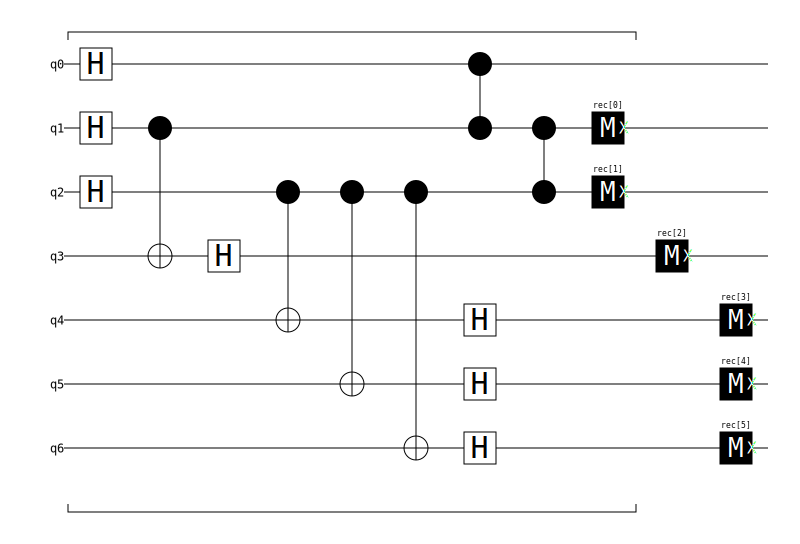

In [19]:
import stim
c = stim.Circuit("""
H 0 1 2
CX 1 3
H 3
CX 2 4 2 5 2 6
H 4 5 6
CZ 0 1 1 2
MX 1 2
TICK
MX 3
TICK
MX 4 5 6
""")

c.diagram('timeline-svg')

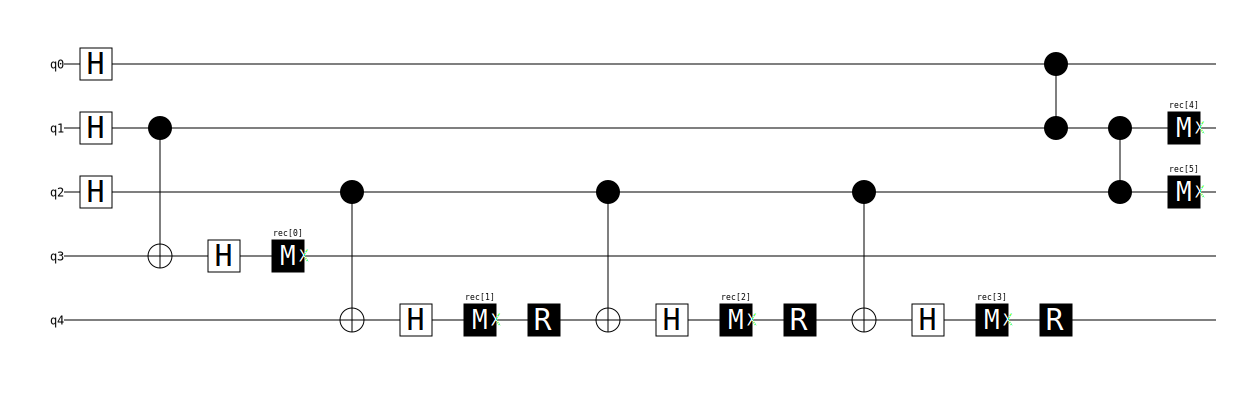

In [20]:
import stim
c = stim.Circuit("""
H 0 1 2
CX 1 3
H 3
MX 3
CX 2 4
H 4
MX 4
R 4
CX 2 4
H 4
MX 4
R 4
CX 2 4
H 4
MX 4
R 4
CZ 0 1 1 2
MX 1 2
""")

c.diagram('timeline-svg')

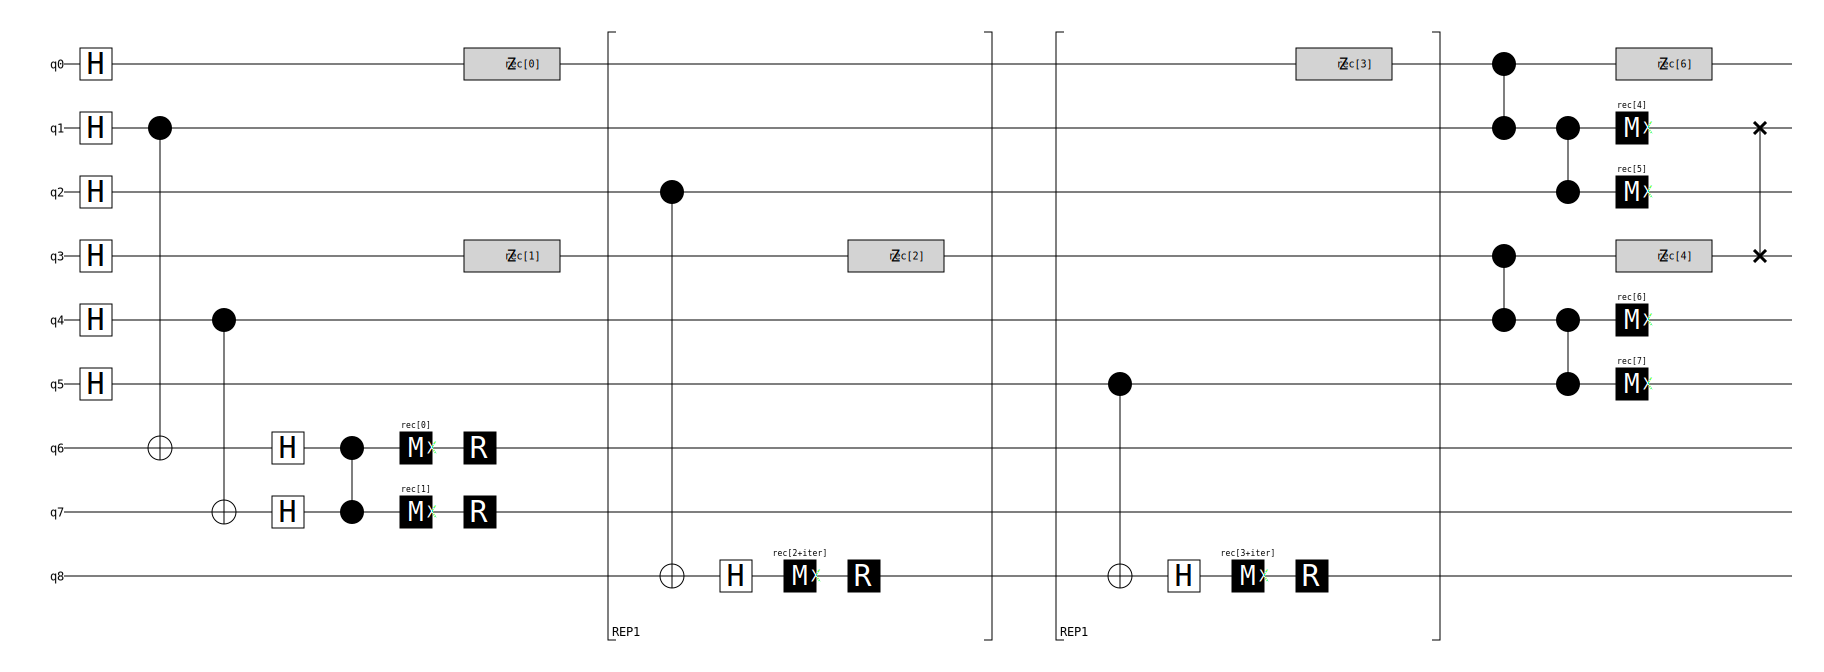

In [21]:
import stim
# anchor  0 3
# outer-e 1 4
# inner-e 2 5
# outer-p 6 7
# photon  8
c = stim.Circuit("""
H 0 1 2 3 4 5
CX 1 6 4 7
H 6 7
CZ 6 7
MX 6 7
R 6 7
CZ rec[-1] 3 rec[-2] 0
REPEAT 1 {
    CX 2 8
    H 8
    MX 8
    R 8
    CZ rec[-1] 3
}
REPEAT 1 {
    CX 5 8
    H 8
    MX 8
    R 8
    CZ rec[-1] 0
}
CZ 0 1 3 4 1 2 4 5
MX 1 2 4 5
CZ rec[-2] 0 rec[-4] 3
SWAP 1 3
""")
t = stim.TableauSimulator()
t.do(c)
t.canonical_stabilizers()
display(c.diagram('timeline-svg'))
for _ in range(1000):
    t = stim.TableauSimulator()
    t.do(c)
    # t.canonical_stabilizers()
    # assert t.peek_observable_expectation(stim.PauliString('ZX')) == 1
    # assert t.peek_observable_expectation(stim.PauliString('XZ')) == 1

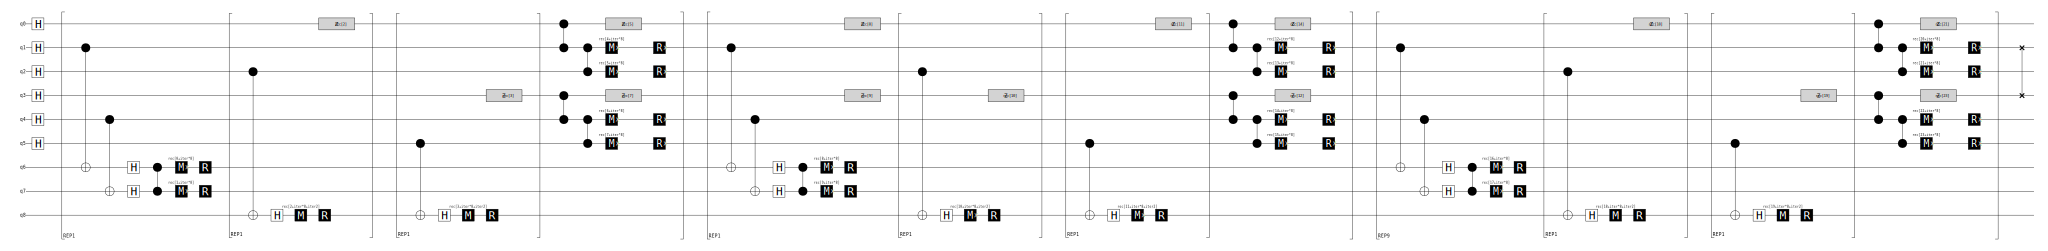

In [22]:
import stim

for i in range(100):

    mz_before = np.random.randint(1, 10)
    mz_after = np.random.randint(1, 10)

    # anchor  0 3
    # outer-e 1 4
    # inner-e 2 5
    # outer-p 6 7
    # photon  8
    c = stim.Circuit(f"""
    H 0 1 2 3 4 5
    # MZ Part
    REPEAT {mz_before} {{
        CX 1 6 4 7
        H 6 7
        CZ 6 7
        MX 6 7
        R 6 7
        REPEAT 1 {{
            CX 2 8
            H 8
            MZ 8
            R 8
            CZ rec[-1] 0
        }}
        REPEAT 1 {{
            CX 5 8
            H 8
            MZ 8
            R 8
            CZ rec[-1] 3
        }}
        CZ 0 1 3 4 1 2 4 5
        MX 1 2 4 5
        CZ rec[-1] 3 rec[-3] 0
        RX 1 2 4 5
    }}
    # MX Part
    REPEAT {1} {{
        CX 1 6 4 7
        H 6 7
        CZ 6 7
        MX 6 7
        R 6 7
        CZ rec[-1] 3 rec[-2] 0
        REPEAT 1 {{
            CX 2 8
            H 8
            MX 8
            R 8
            CZ rec[-1] 3
        }}
        REPEAT 1 {{
            CX 5 8
            H 8
            MX 8
            R 8
            CZ rec[-1] 0
        }}
        CZ 0 1 3 4 1 2 4 5
        MX 1 2 4 5
        CZ rec[-2] 0 rec[-4] 3
        RX 1 2 4 5
    }}
    # MZ Part
    REPEAT {mz_after} {{
        CX 1 6 4 7
        H 6 7
        CZ 6 7
        MX 6 7
        R 6 7
        REPEAT 1 {{
            CX 2 8
            H 8
            MZ 8
            R 8
            CZ rec[-1] 0
        }}
        REPEAT 1 {{
            CX 5 8
            H 8
            MZ 8
            R 8
            CZ rec[-1] 3
        }}
        CZ 0 1 3 4 1 2 4 5
        MX 1 2 4 5
        CZ rec[-1] 3 rec[-3] 0
        RX 1 2 4 5
    }}
    SWAP 1 3
    """)
    if i == 0:
        display(c.diagram('timeline-svg'))
    # t = stim.TableauSimulator()
    # t.do(c)
    for _ in range(1000):
        t = stim.TableauSimulator()
        t.do(c)
        t.canonical_stabilizers()
        # assert t.peek_observable_expectation(stim.PauliString('ZX')) == 1
        # assert t.peek_observable_expectation(stim.PauliString('XZ')) == 1
# t.canonical_stabilizers()

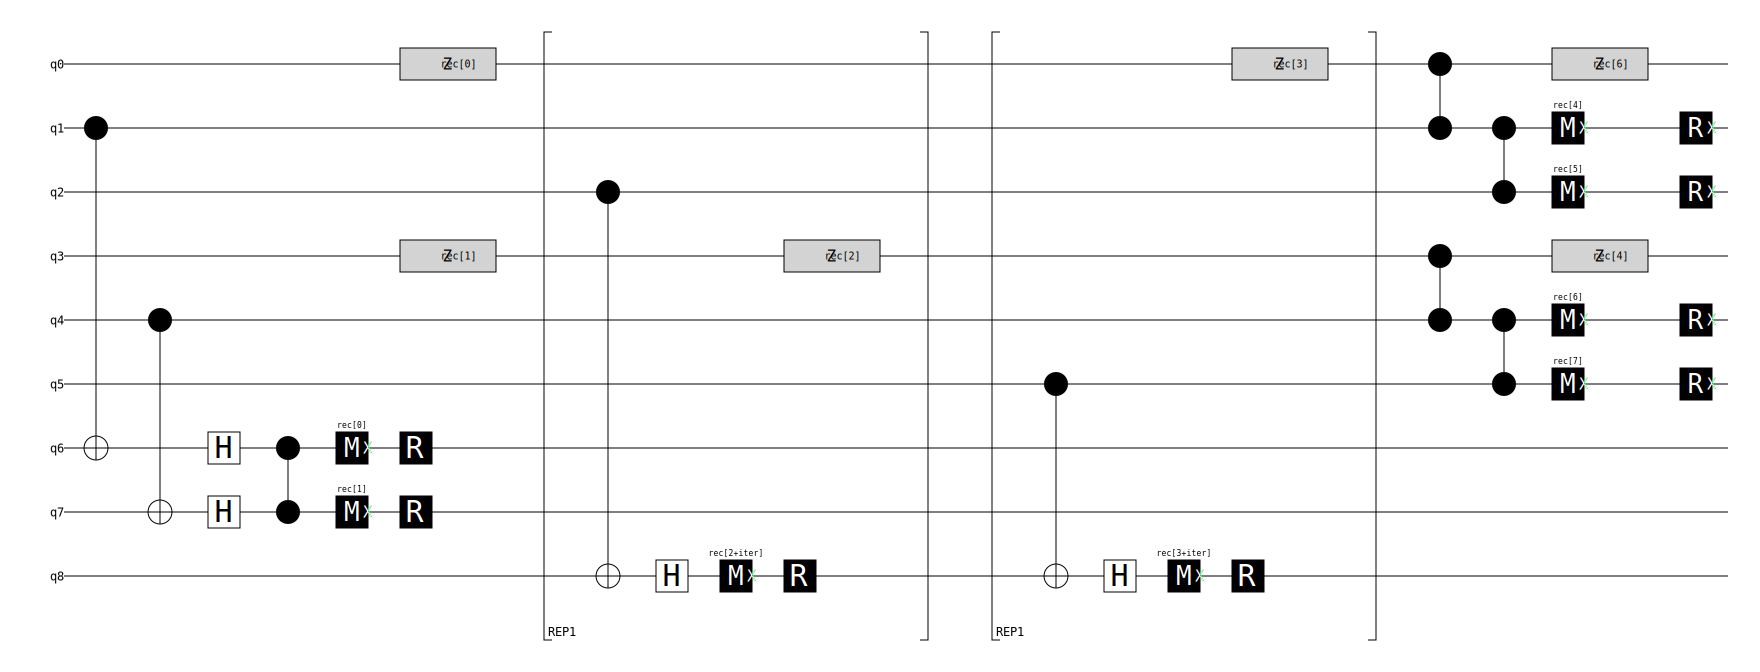

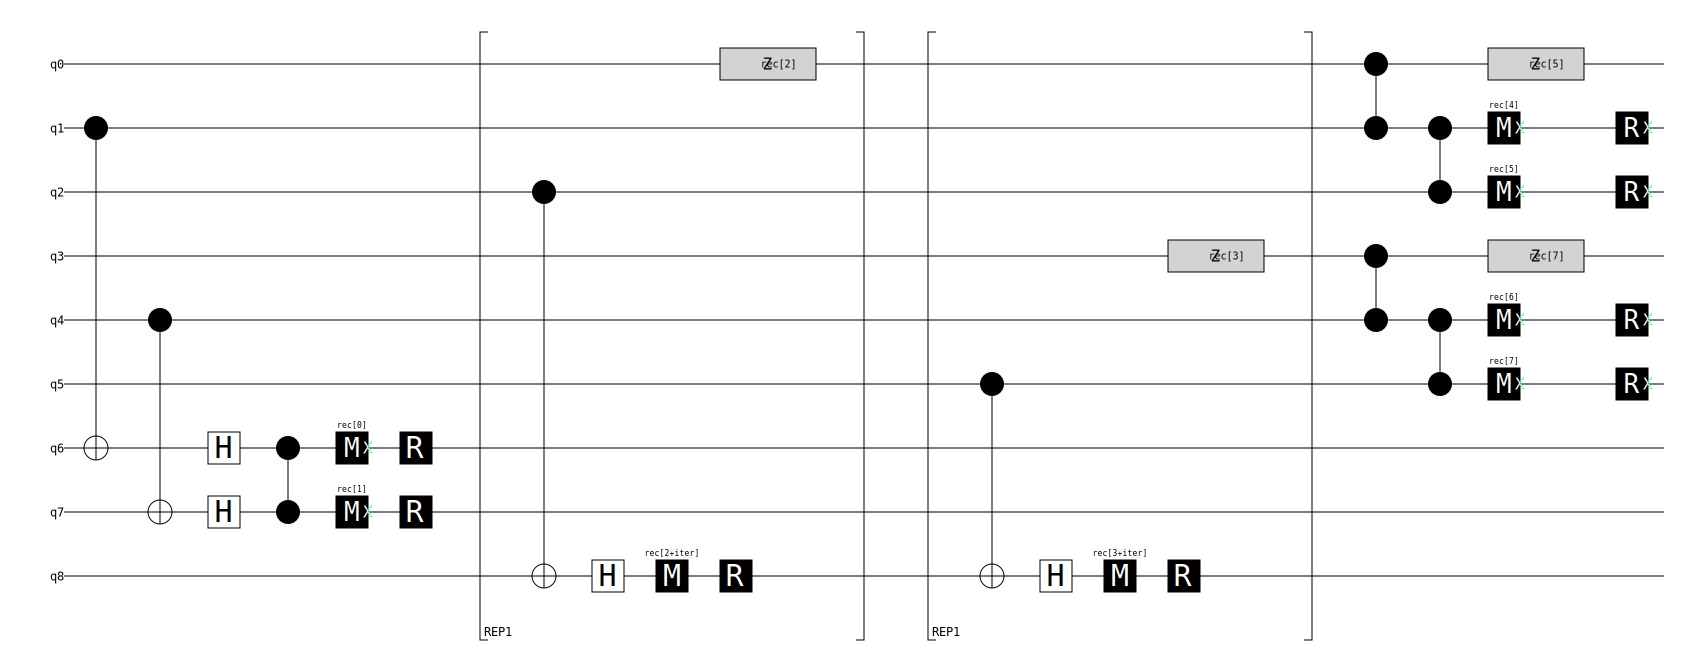

In [23]:
import stim

init_circuit = stim.Circuit(""" 
H 0 1 2 3 4 5
""")
mz_circuit = stim.Circuit(f"""
    CX 1 6 4 7
    H 6 7
    CZ 6 7
    MX 6 7
    R 6 7
    REPEAT 1 {{
        CX 2 8
        H 8
        MZ 8
        R 8
        CZ rec[-1] 0
    }}
    REPEAT 1 {{
        CX 5 8
        H 8
        MZ 8
        R 8
        CZ rec[-1] 3
    }}
    CZ 0 1 3 4 1 2 4 5
    MX 1 2 4 5
    CZ rec[-1] 3 rec[-3] 0
    RX 1 2 4 5
""")
mx_circuit = stim.Circuit("""
    CX 1 6 4 7
    H 6 7
    CZ 6 7
    MX 6 7
    R 6 7
    CZ rec[-1] 3 rec[-2] 0
    REPEAT 1 {
        CX 2 8
        H 8
        MX 8
        R 8
        CZ rec[-1] 3
    }
    REPEAT 1 {
        CX 5 8
        H 8
        MX 8
        R 8
        CZ rec[-1] 0
    }
    CZ 0 1 3 4 1 2 4 5
    MX 1 2 4 5
    CZ rec[-2] 0 rec[-4] 3
    RX 1 2 4 5
""")
display(mx_circuit.diagram('timeline-svg'))
display(mz_circuit.diagram('timeline-svg'))

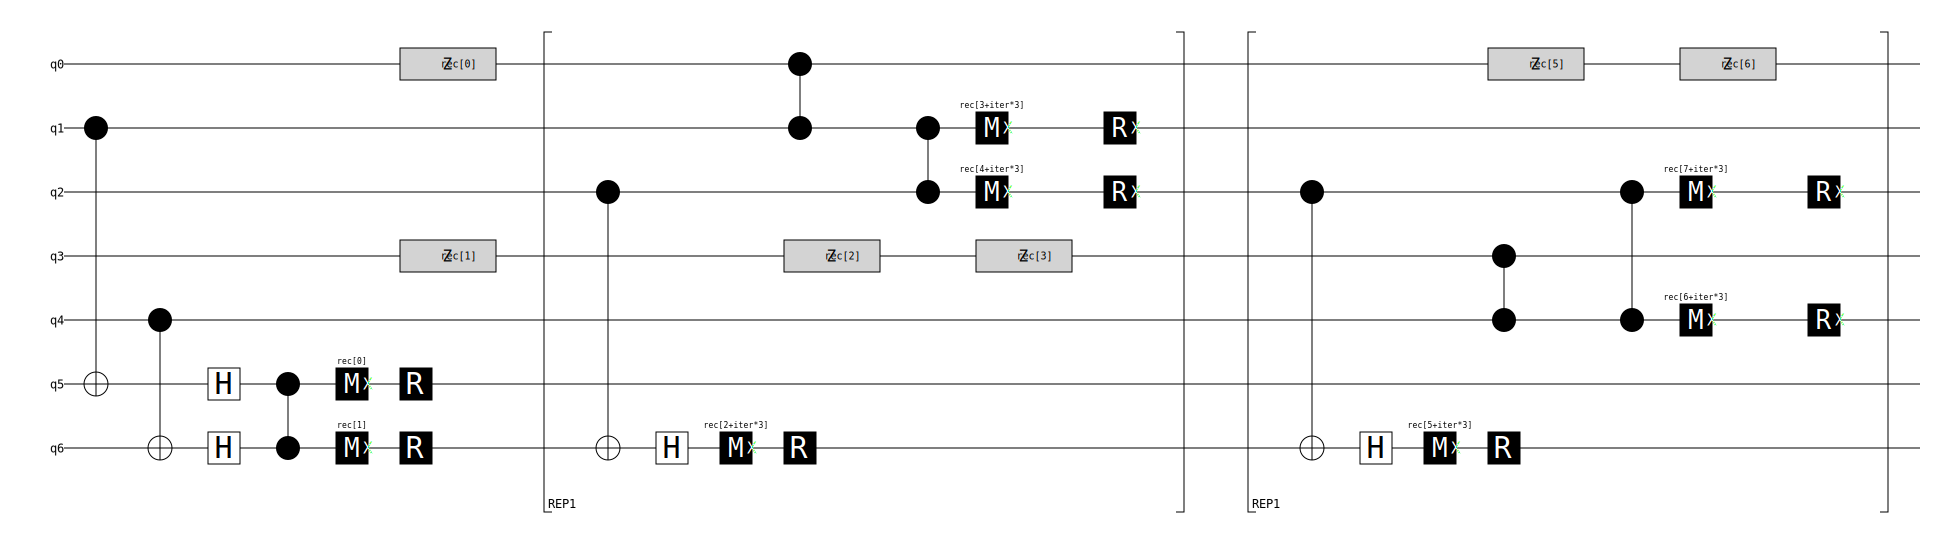

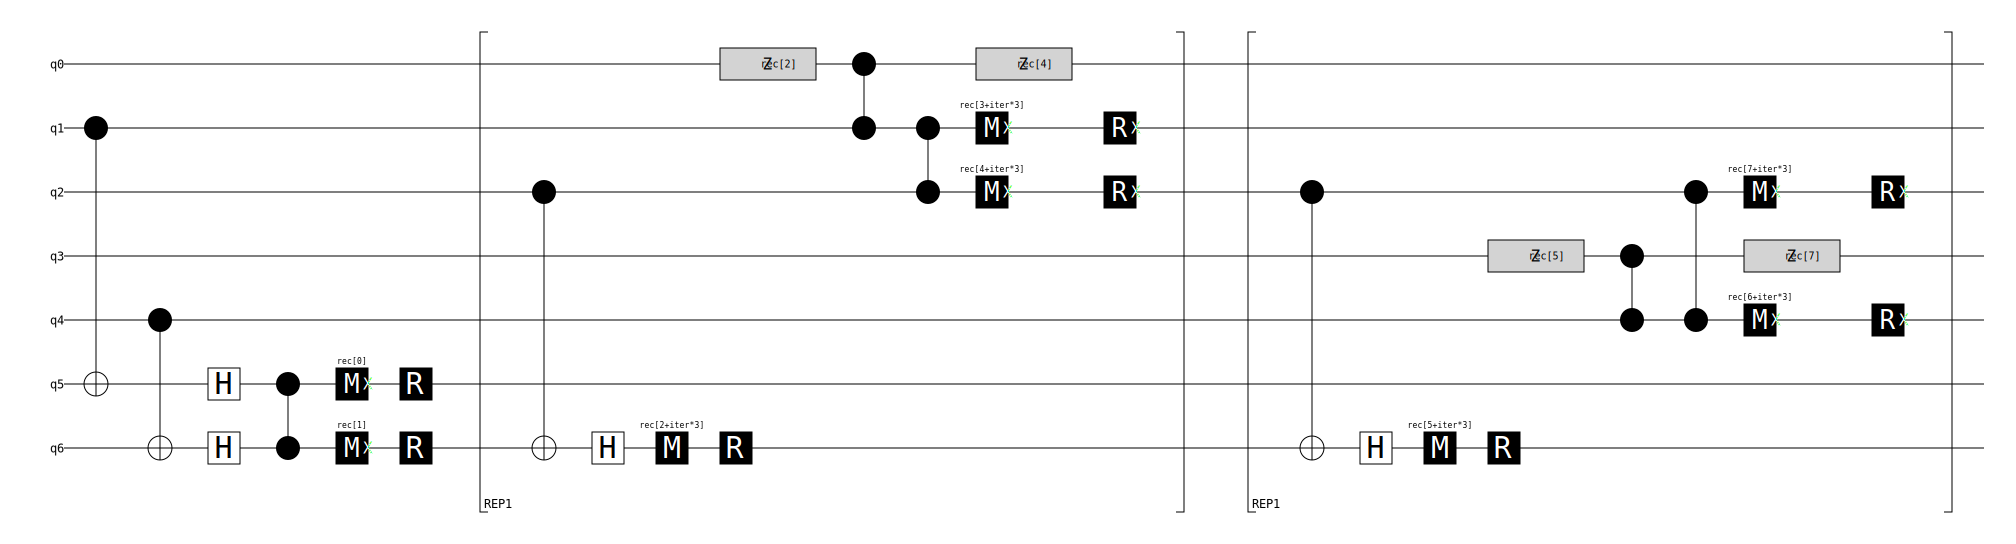

In [24]:
import stim
import numpy as np

init_circuit = stim.Circuit(""" 
H 0 1 2 3 4 5
""")
old_mz_circuit = stim.Circuit(f"""
    CX 1 6 4 7
    H 6 7
    CZ 6 7
    MX 6 7
    R 6 7
    REPEAT 1 {{
        CX 2 7
        H 7
        MZ 7
        R 7
        CZ rec[-1] 0
    }}

    REPEAT 1 {{
        CX 5 7
        H 7
        MZ 7
        R 7
        CZ rec[-1] 3
    }}
    CZ 0 1 3 4 1 2 4 5
    MX 1 2 4 5
    CZ rec[-1] 3 rec[-3] 0
    RX 1 2 4 5
""")
mz_circuit = stim.Circuit(f"""
    CX 1 5 4 6
    H 5 6
    CZ 5 6
    MX 5 6
    R 5 6
    REPEAT 1 {{
        CX 2 6
        H 6
        MZ 6
        R 6
        CZ rec[-1] 0
        CZ 0 1 1 2
        MX 1 2
        CZ rec[-1] 0
        RX 1 2
    }}

    REPEAT 1 {{
        CX 2 6
        H 6
        MZ 6
        R 6
        CZ rec[-1] 3
        CZ 3 4 4 2
        MX 4 2
        CZ rec[-1] 3 
        RX 4 2
    }}
""")
mx_circuit = stim.Circuit("""
    CX 1 5 4 6
    H 5 6
    CZ 5 6
    MX 5 6
    R 5 6
    CZ rec[-1] 3 rec[-2] 0
    REPEAT 1 {
        CX 2 6
        H 6
        MX 6
        R 6
        CZ rec[-1] 3
        CZ 0 1 1 2
        MX 1 2
        CZ rec[-2] 3
        RX 1 2
    }
    REPEAT 1 {
        CX 2 6
        H 6
        MX 6
        R 6
        CZ rec[-1] 0
        CZ 3 4 4 2
        MX 4 2
        CZ rec[-2] 0
        RX 2 4
    }
""")
# display(mx_circuit.diagram('timeline-svg'))
display(mx_circuit.diagram('timeline-svg'))
display(mz_circuit.diagram('timeline-svg'))
# display(old_mz_circuit.diagram('timeline-svg'))

for mz_before in range(5):
    for mz_after in range(5):

        circuit = init_circuit
        for _ in range(mz_before):
            circuit += mz_circuit
        circuit += mx_circuit
        for _ in range(mz_after):
            circuit += mz_circuit
        circuit.append("SWAP", [1, 3])

        if mz_before == 1 and mz_after == 1:
            display(circuit.diagram('timeline-svg'))

        t = stim.TableauSimulator()
        for _ in range(1000):
            t.reset(*range(9))
            t.do(c)
            t.canonical_stabilizers()
            # assert t.peek_observable_expectation(stim.PauliString('ZX')) == 1
            # assert t.peek_observable_expectation(stim.PauliString('XZ')) == 1